In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '../src/')
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.base import clone
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
from datetime import datetime

from preprocessing import BagOfNotes, MidiPathToDataFrame, PreprocessMidiDataFrame, NfIsf, BagOfChords2, Downsampler
import evaluation

In [3]:
data_dir = Path('../maestro/maestro-v3.0.0/')
# df = pd.read_csv(data_dir / 'maestro-v3.0.0.csv')
df = pd.read_csv('../eda/no_dups.csv')
keys = pd.read_csv('../eda/key_review.csv')
categories = pd.read_csv('../eda/categories.csv')
df = pd.merge(df, keys, how='left', on='canonical_title')
df = pd.merge(df, categories, how='left', on='canonical_title')
df.head()

,Unnamed: 0,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration,draft_key,category
0,0,Alban Berg,Sonata Op. 1,train,2018,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,698.661160,NaN,sonata
1,3,Alexander Scriabin,"24 Preludes Op. 11, No. 13-24",train,2004,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,872.640588,NaN,prelude
2,4,Alexander Scriabin,"3 Etudes, Op. 65",validation,2006,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,397.857508,NaN,etude
3,5,Alexander Scriabin,"5 Preludes, Op.15",validation,2009,2009/MIDI-Unprocessed_07_R1_2009_04-05_ORIG_MI...,2009/MIDI-Unprocessed_07_R1_2009_04-05_ORIG_MI...,400.557826,NaN,prelude
4,6,Alexander Scriabin,"Entragete, Op.63",test,2009,2009/MIDI-Unprocessed_11_R1_2009_06-09_ORIG_MI...,2009/MIDI-Unprocessed_11_R1_2009_06-09_ORIG_MI...,163.745830,NaN,NaN


In [4]:
train = df[df.split == 'train']
validate = df[df.split == 'validation']

In [5]:
print(train.shape)

(507, 10)


In [6]:
do_once = Pipeline([
    ('loader', MidiPathToDataFrame(data_dir)),
    ('cleaner', PreprocessMidiDataFrame()),
])
train_loaded = do_once.transform(train.midi_filename)
val_loaded = do_once.transform(validate.midi_filename)


C:\Users\benkc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\benkc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


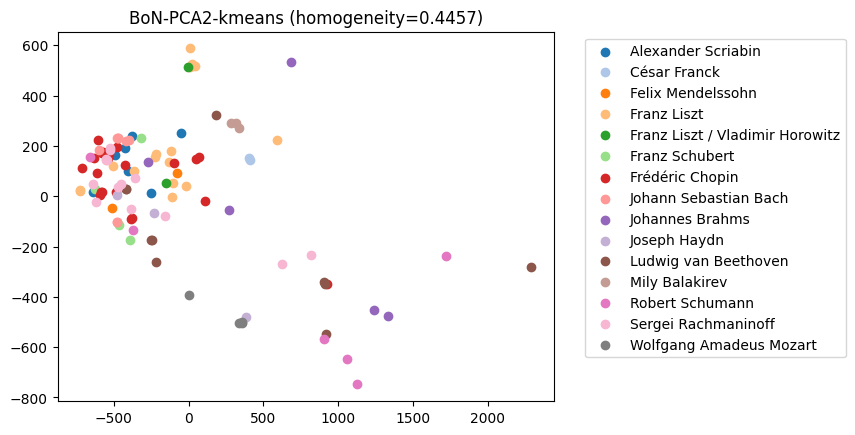

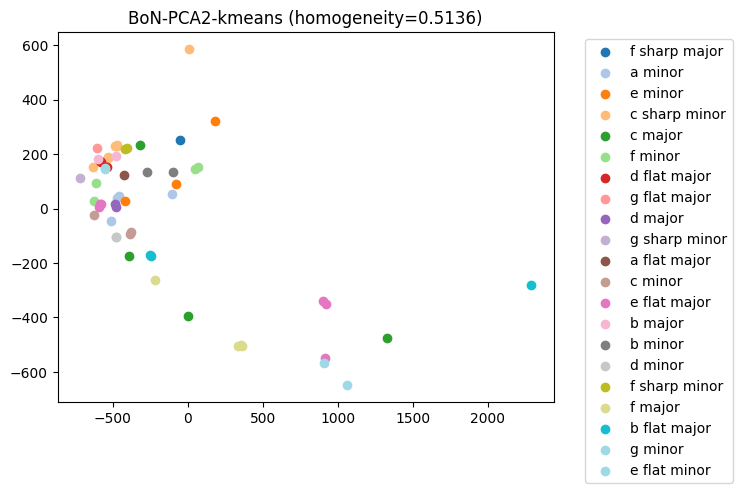

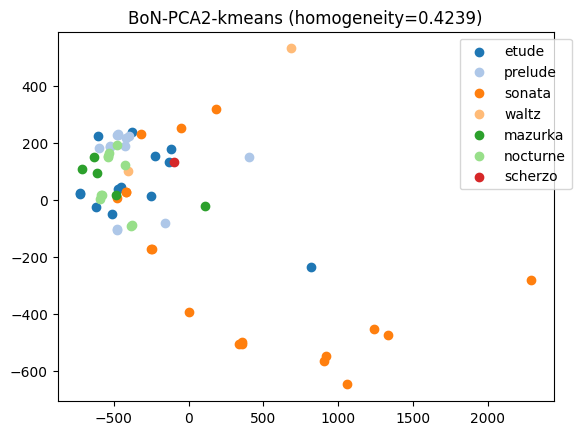

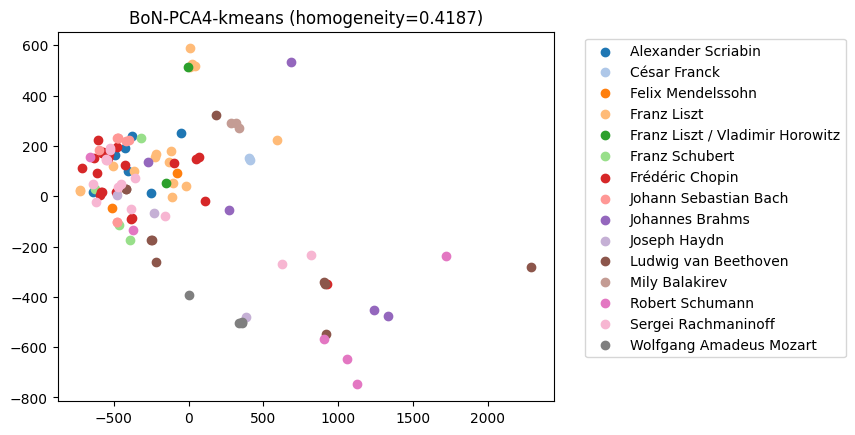

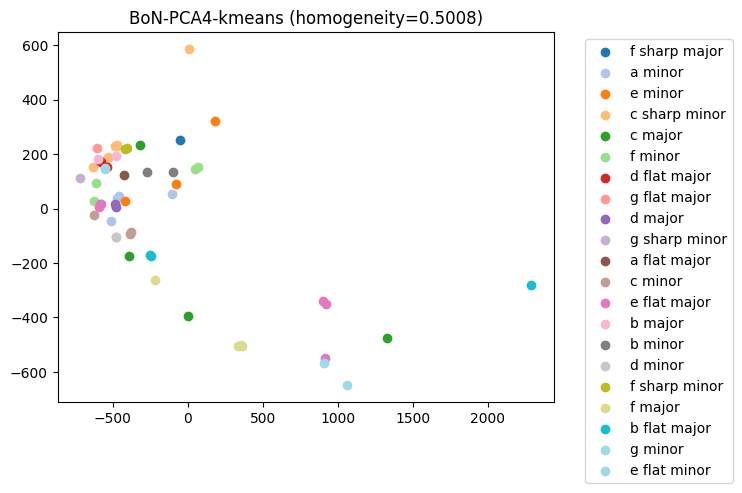

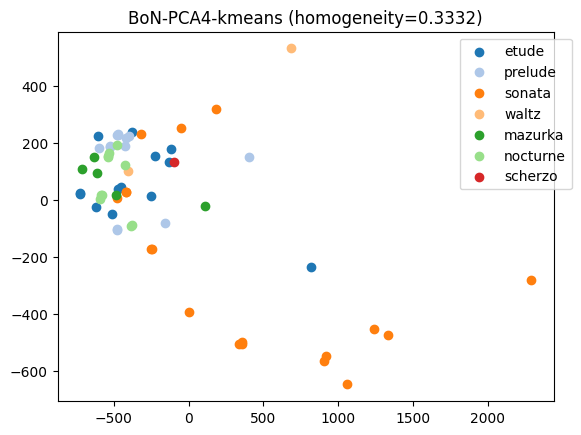

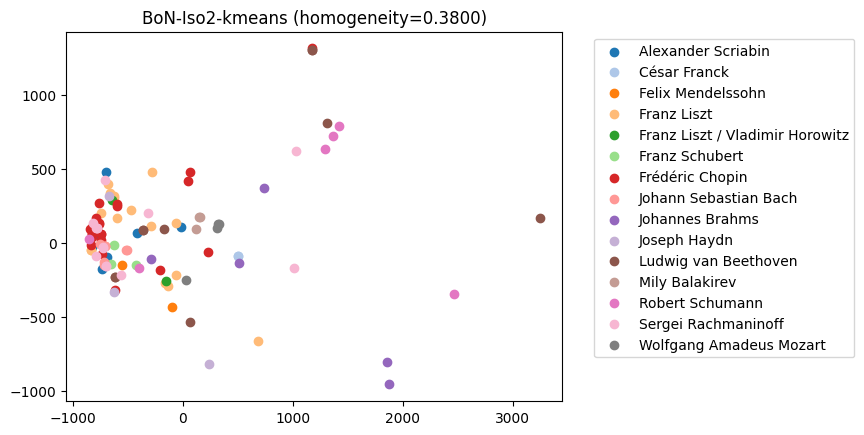

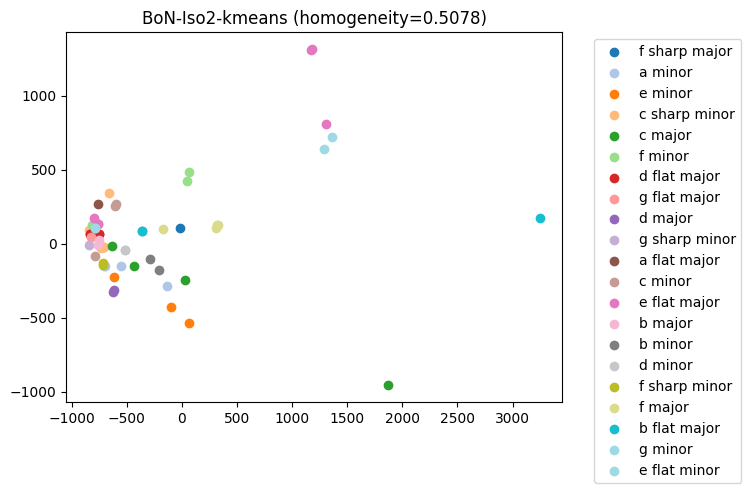

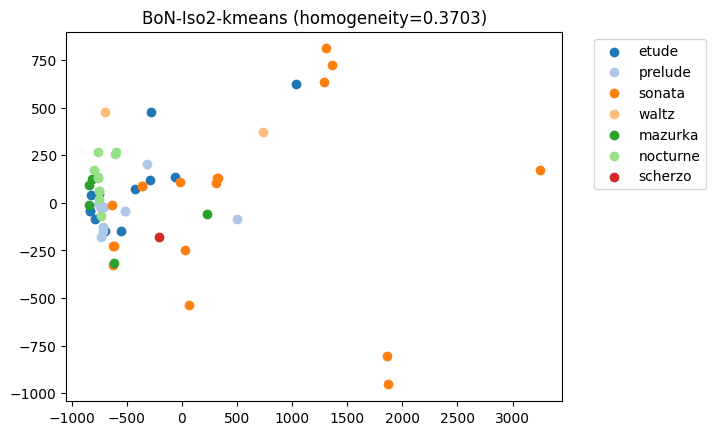

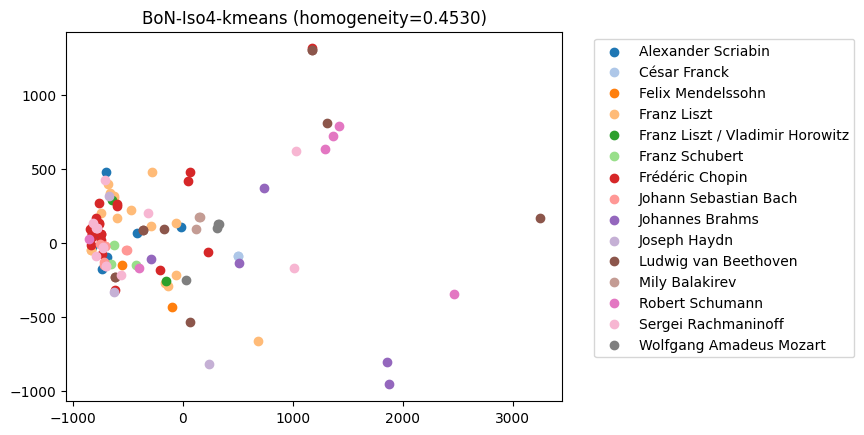

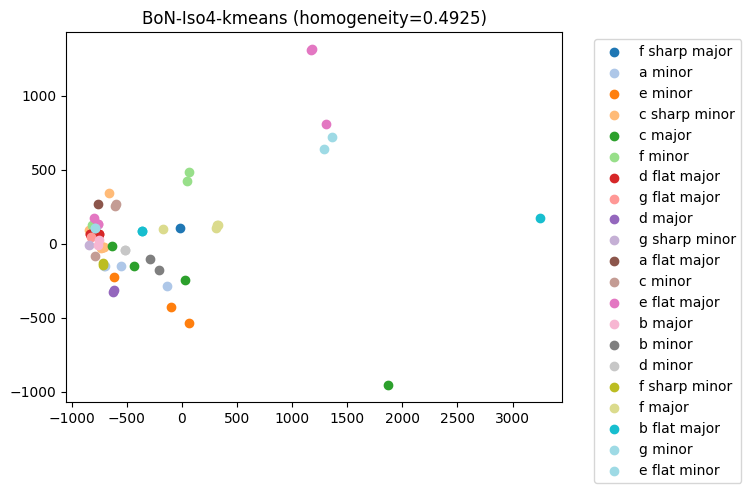

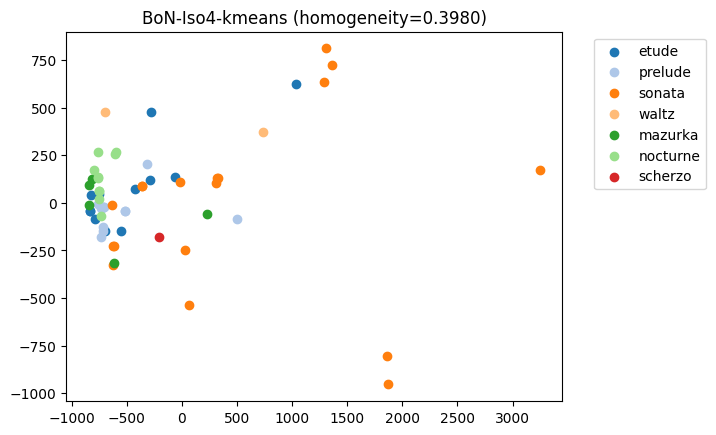

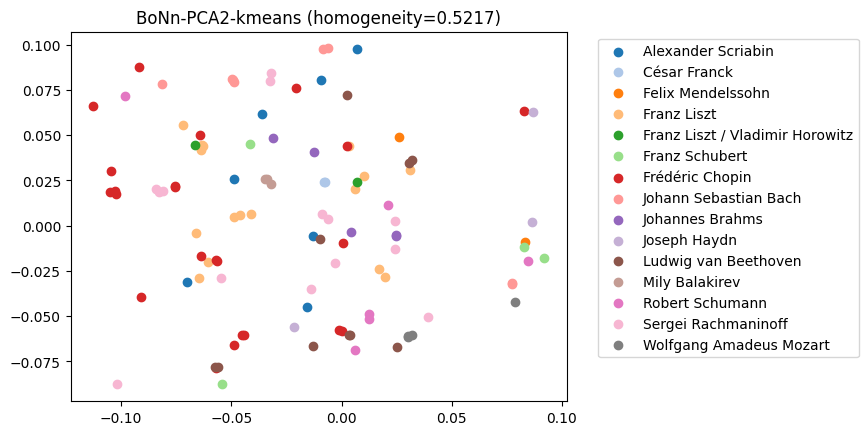

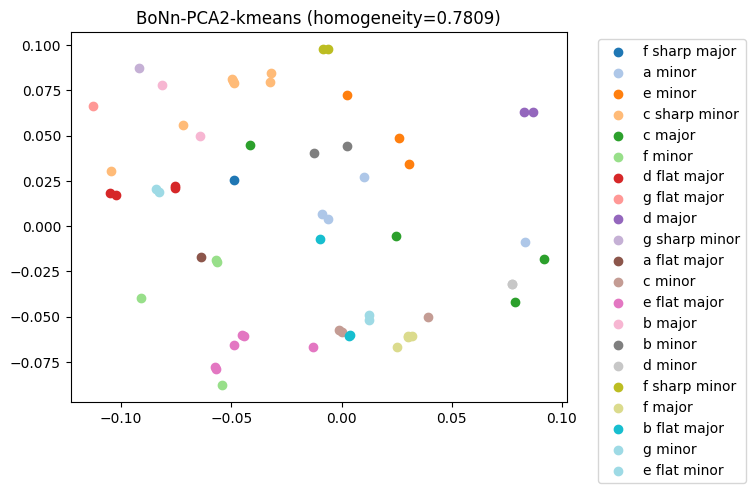

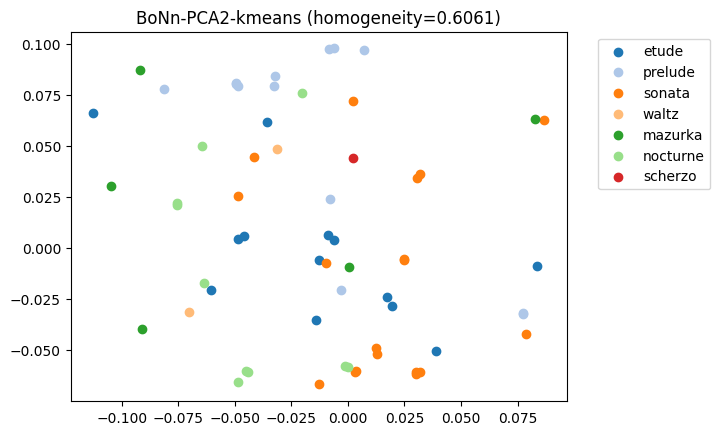

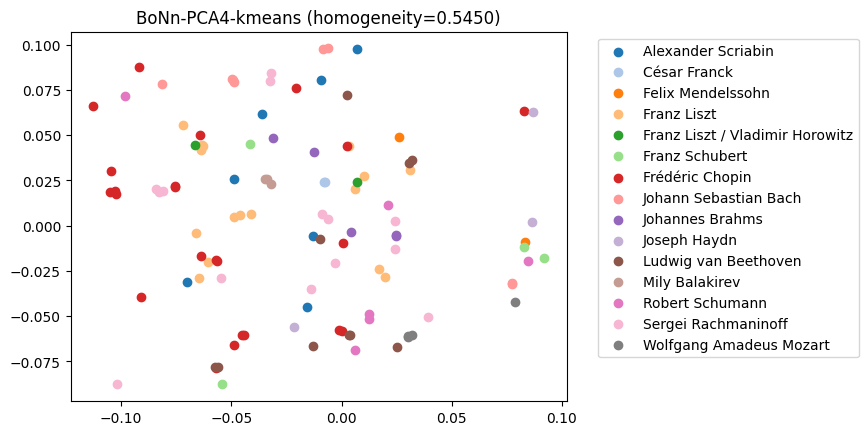

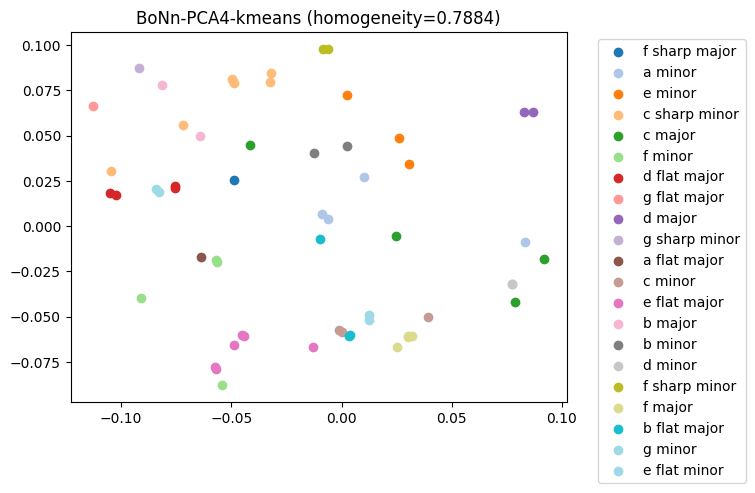

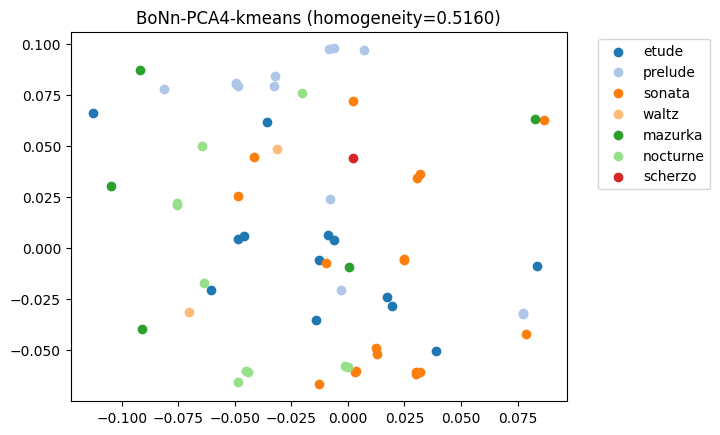

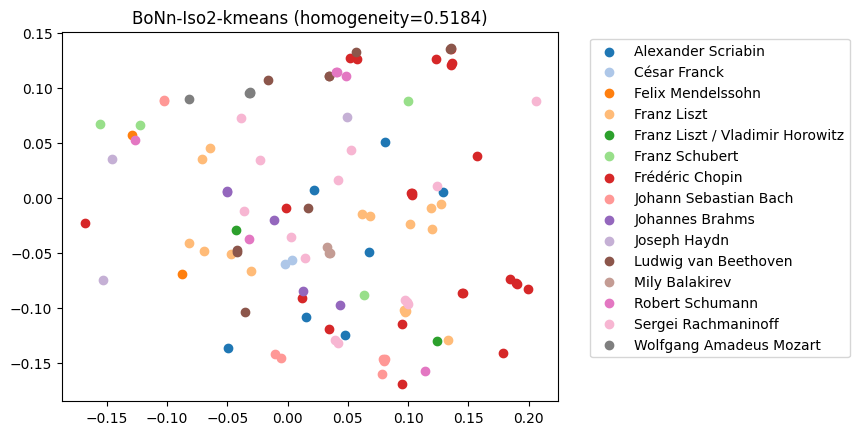

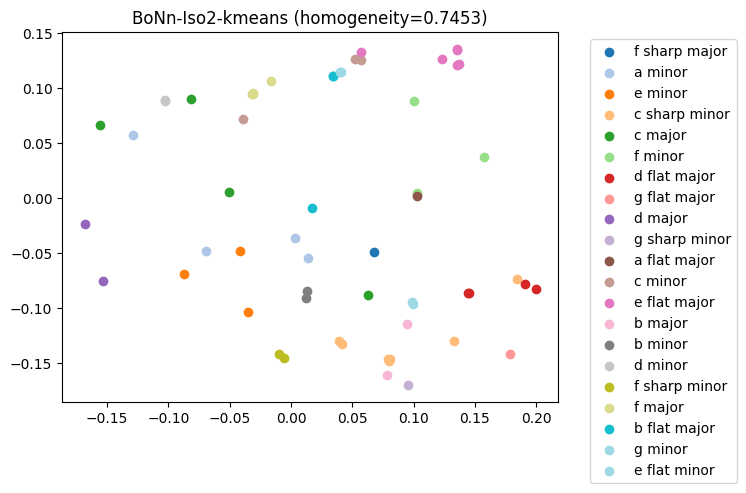

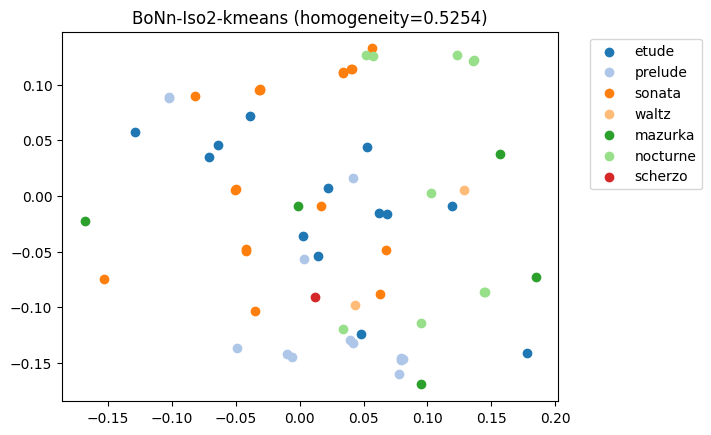

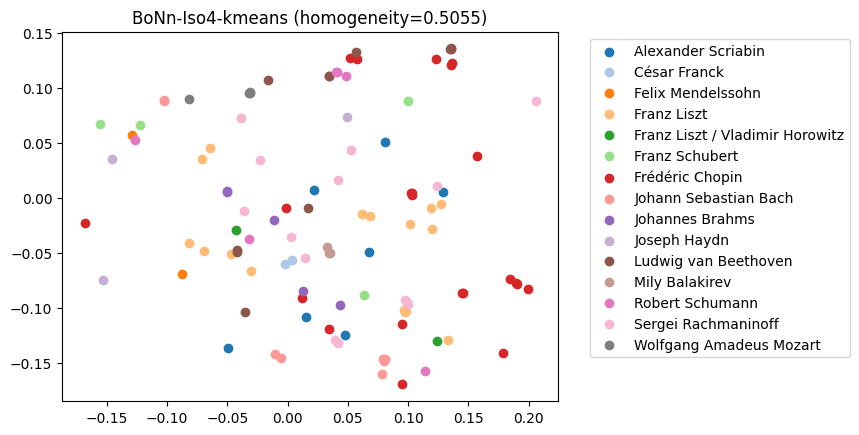

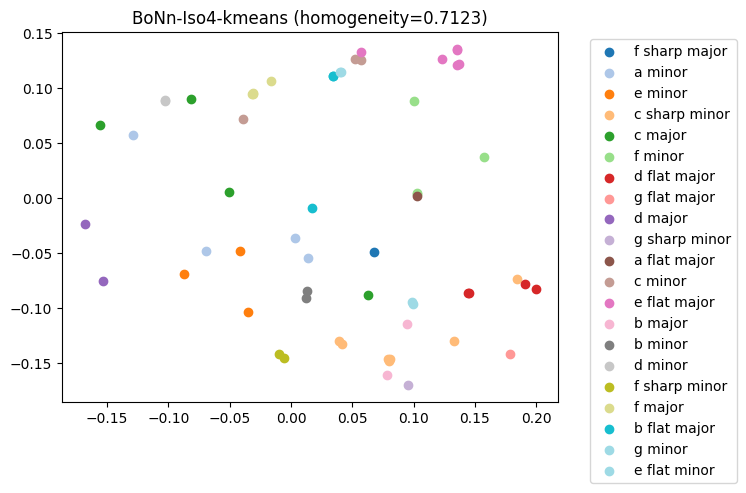

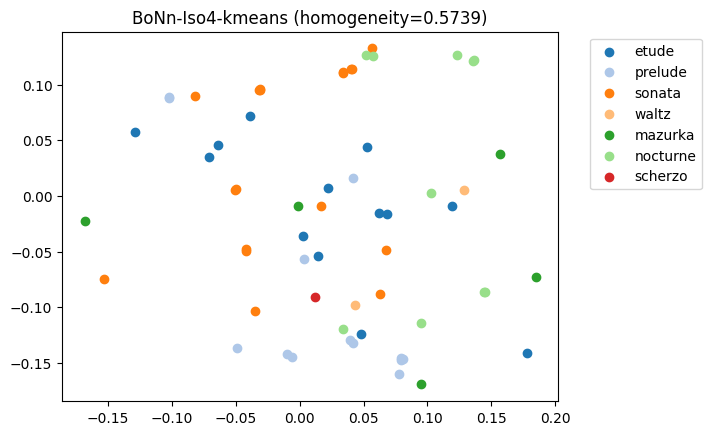

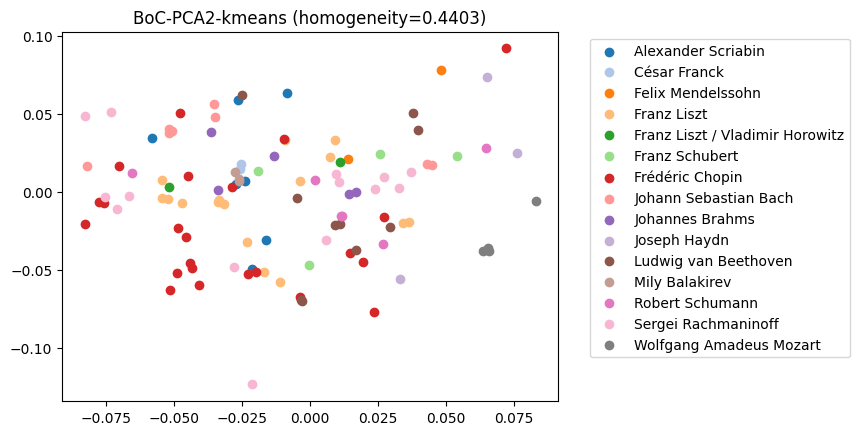

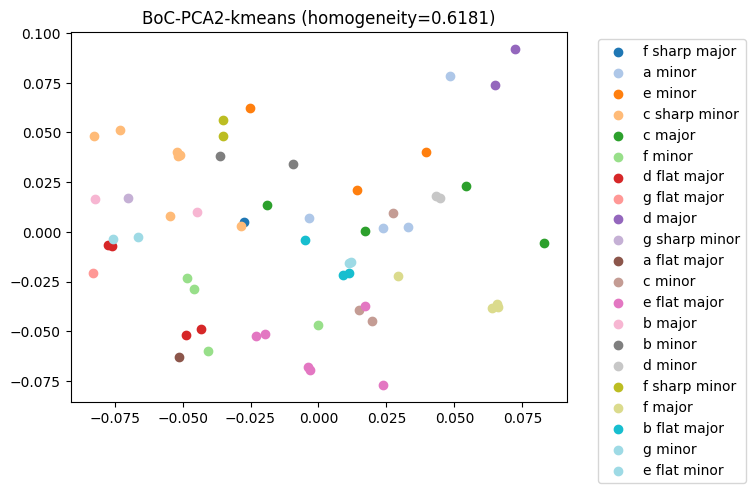

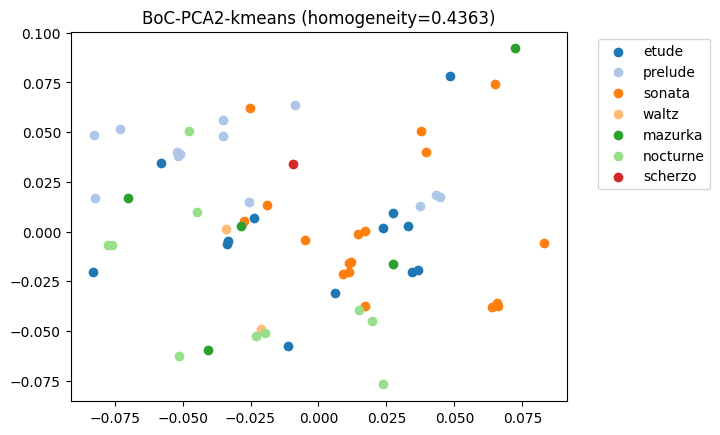

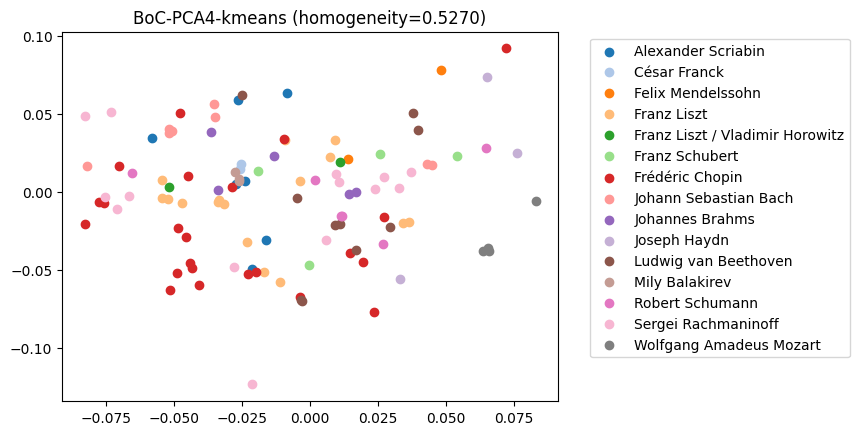

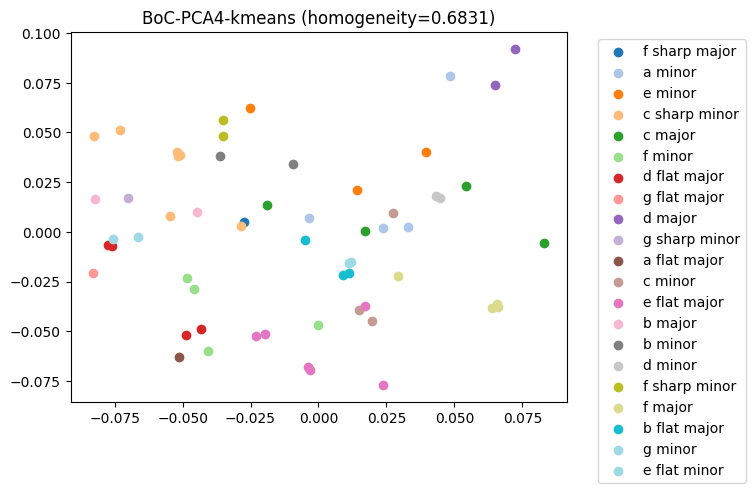

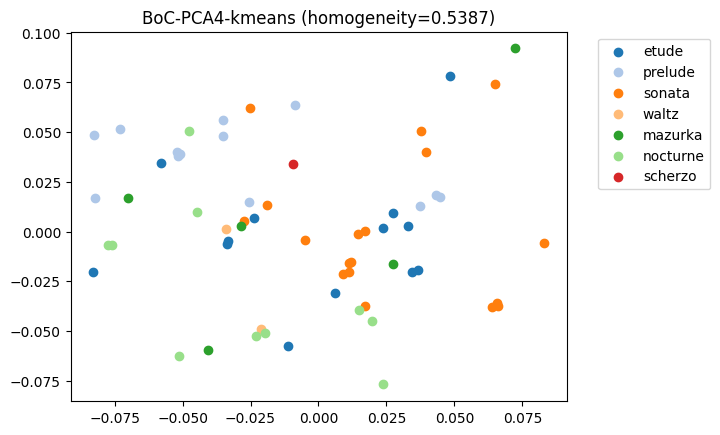

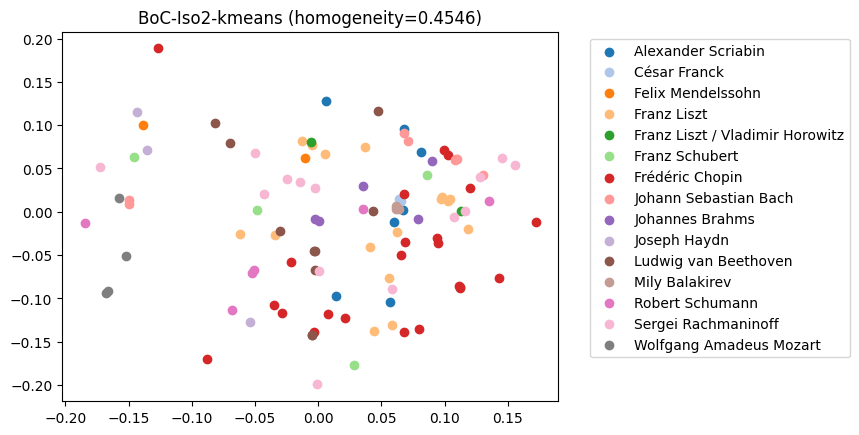

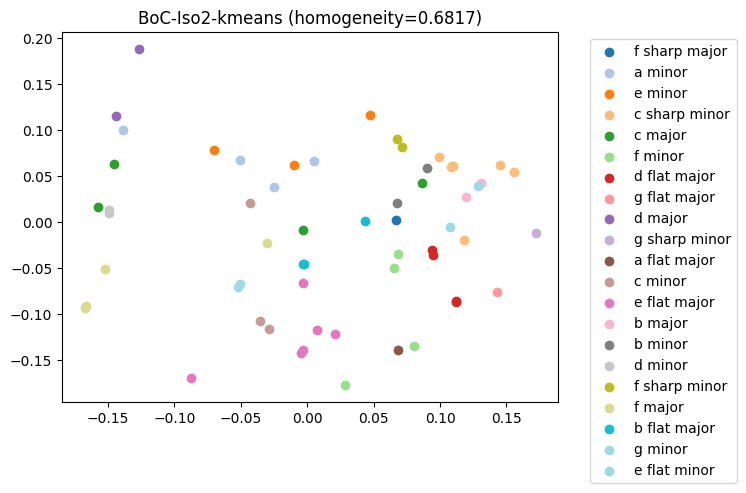

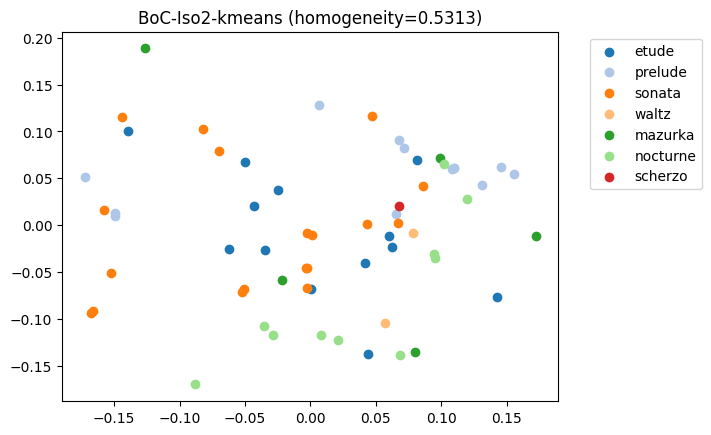

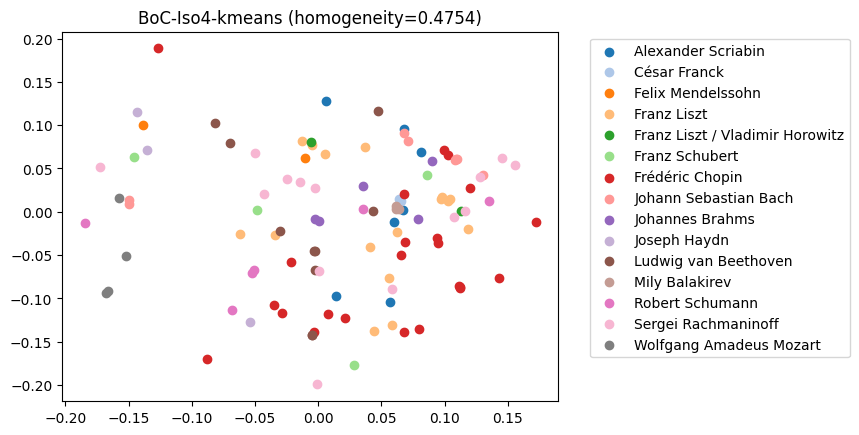

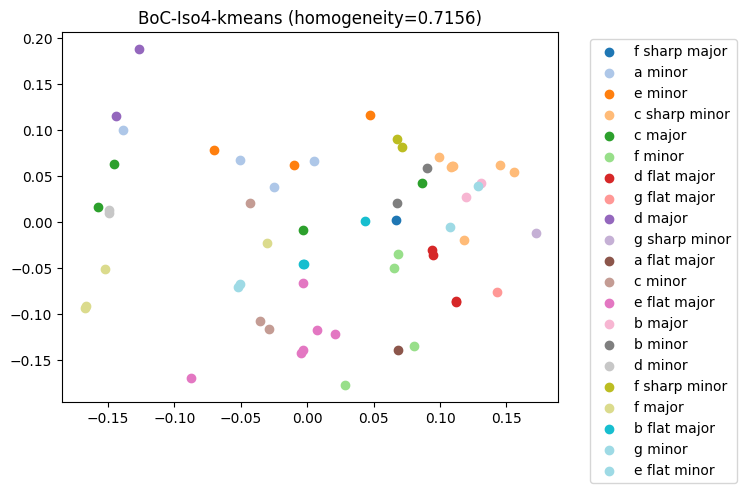

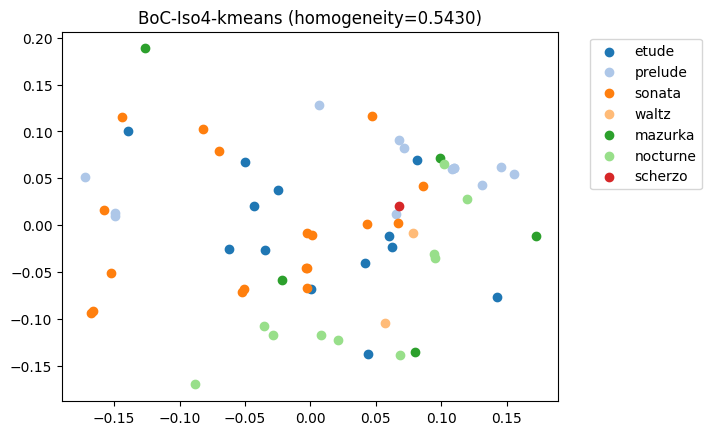

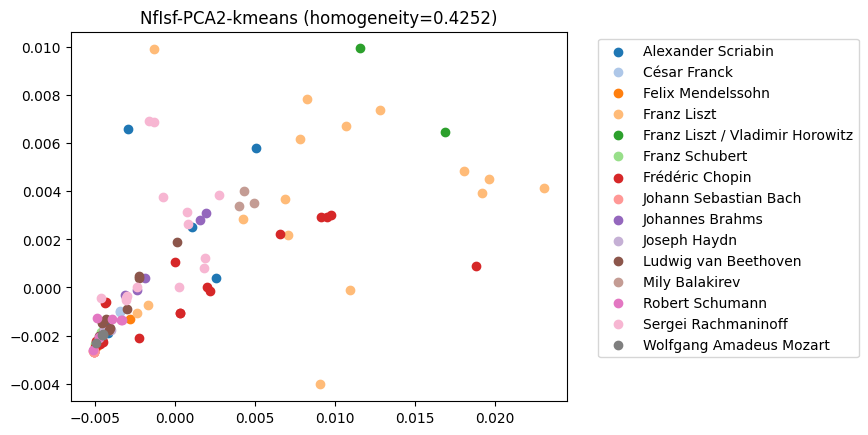

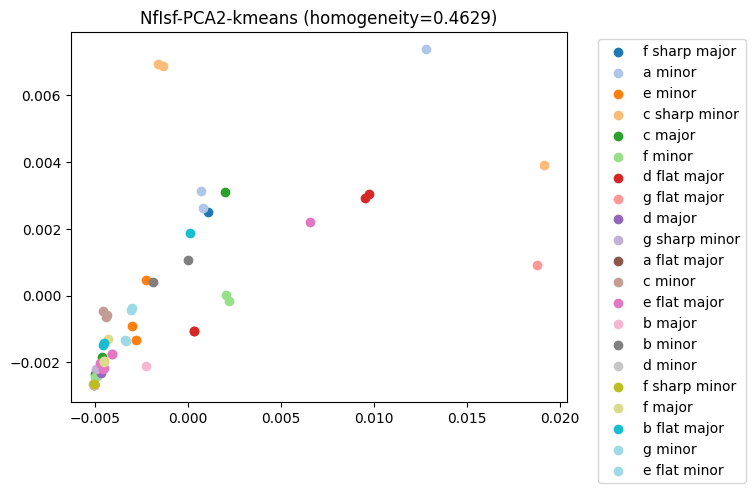

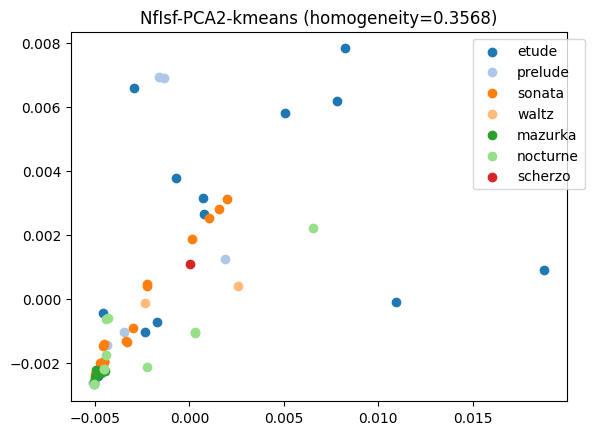

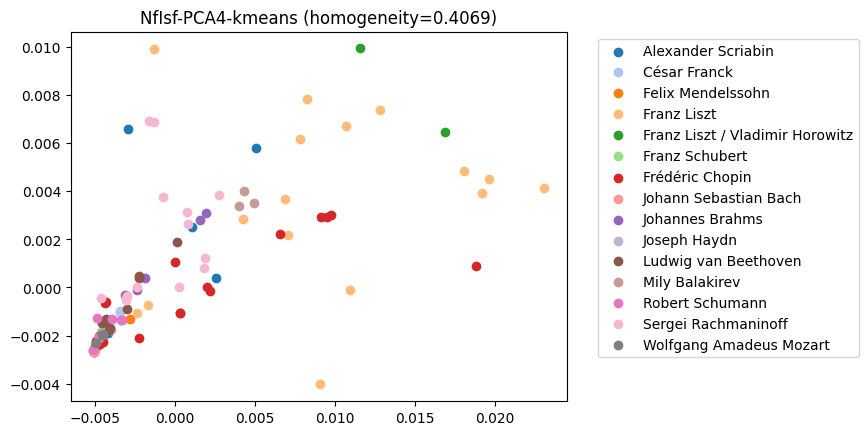

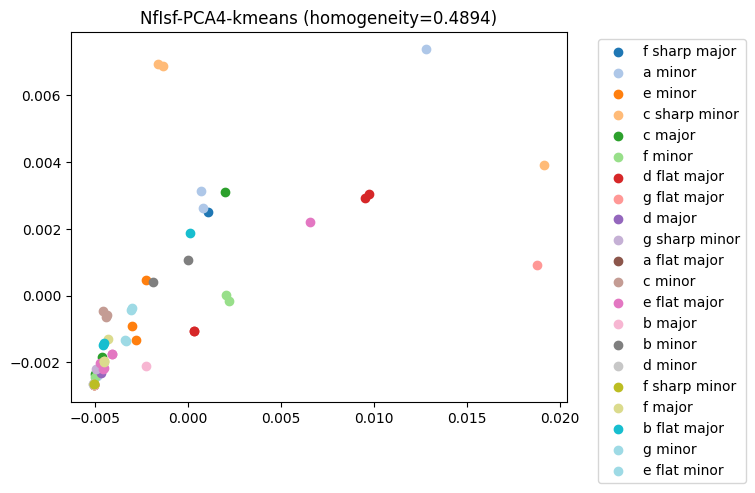

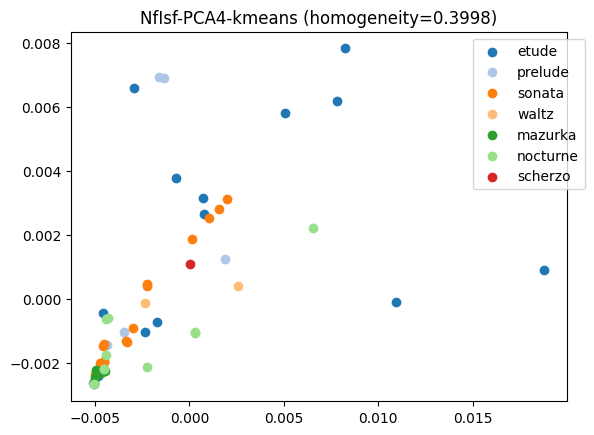

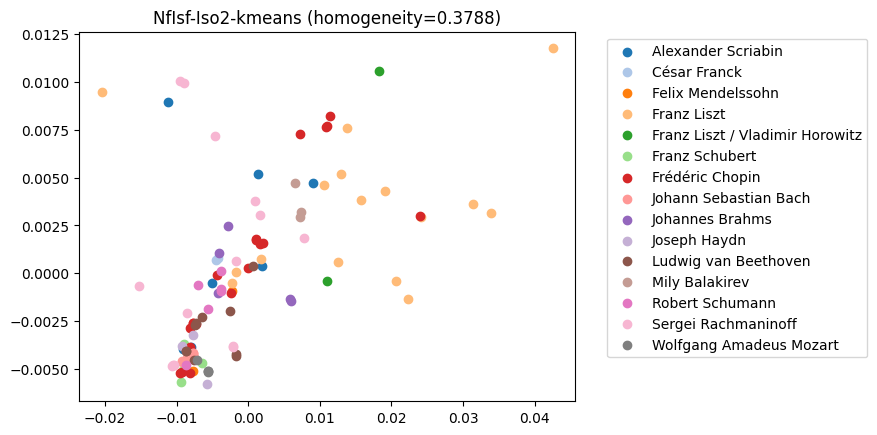

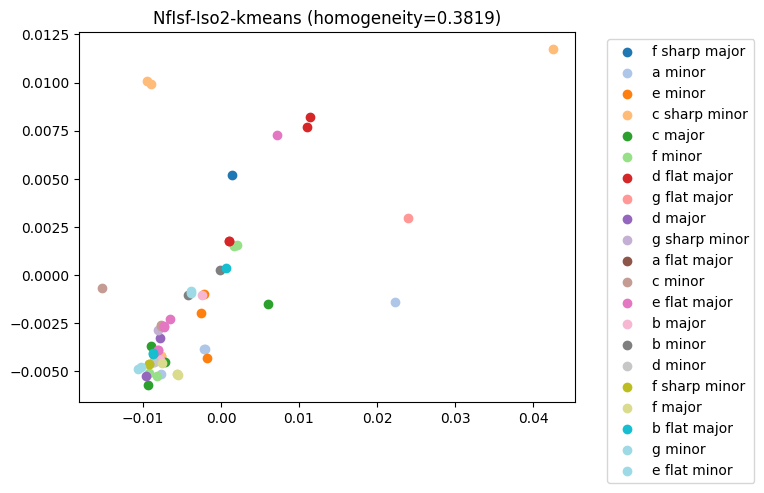

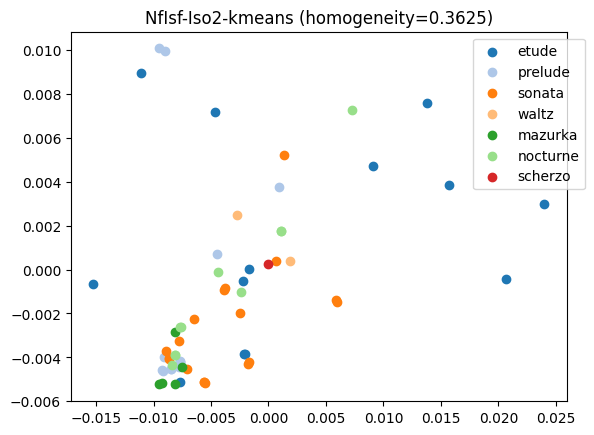

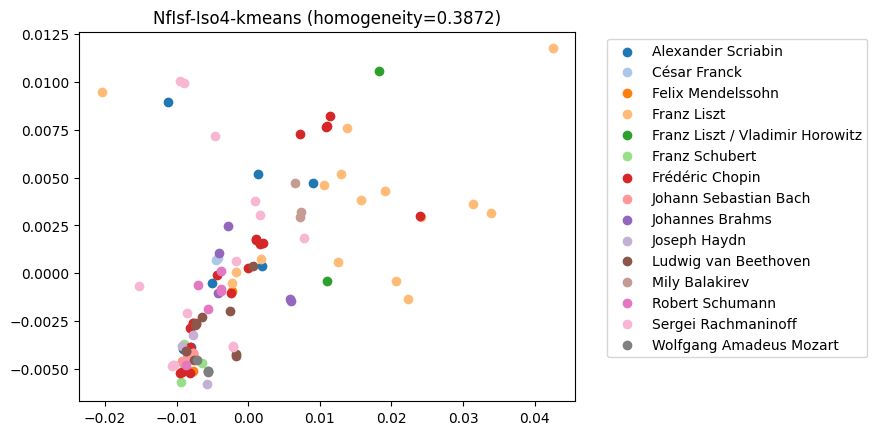

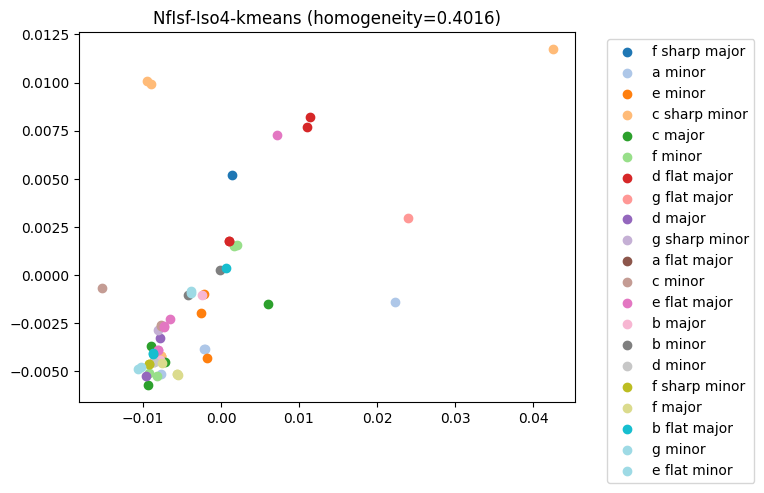

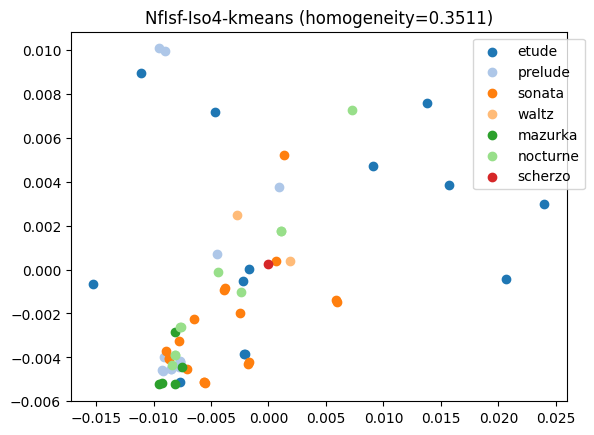

In [7]:
vectorizers = [
    ('BoN', BagOfNotes(normalize=False)),
    ('BoNn', BagOfNotes(normalize=True)),
    ('BoC', BagOfChords2(time_threshold=30, vocab_size=500)),
    # ('BoC', Pipeline([('Downsample', Downsampler(n_samples=500)), ('BoC', BagOfChords2(time_threshold=30, vocab_size=500))])),
    ('NfIsf', NfIsf()),
]
reducers = [
    ('PCA2', PCA(2)),
    ('PCA4', PCA(4)),
    ('Iso2', Isomap(n_neighbors=15, n_components=2)),
    ('Iso4', Isomap(n_neighbors=15, n_components=4)),
]
clusterers = [
    ('kmeans', KMeans(n_clusters=20, n_init=10, random_state=6740*42)),
    # ('spectral', SpectralClustering())
]
models = {}
for v in vectorizers:
    for r in reducers:
        for c in clusterers:
            p = Pipeline([
                v,
                r,
                c,
            ])
            p = clone(p)
            p.fit(train_loaded)
            embeddings = p[:2].transform(val_loaded)
            clusters = p[2].predict(embeddings)
            scores = evaluation.evaluate_clusters(clusters, validate[['canonical_composer', 'draft_key', 'category']])
            name = f'{v[0]}-{r[0]}-{c[0]}'
            for s in scores:
                evaluation.plot_with_label(embeddings, validate[s], f'{name} (homogeneity={scores[s]:.4f})')
            models[name] = p

In [11]:
with open(f'models{datetime.today().strftime('%Y%m%d')}.pkl', 'wb') as f:
    pickle.dump(models, f)